In [1]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 3 - Fall 2021
## Due 5 Oct, 2021

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

For this assignment, download some [sample Ka data](http://www.atmo.ttu.edu/bruning/5331/Ka2140614021408.RAWPXA9.nc). These data were converted directly from the raw format collected by the radar (Sigmet) to the [NetCDF CF/Radial standard](http://ncar.github.io/CfRadial/). No further processing has been applied.

In the file, the radar variables (such as reflectivity) are stored in arrays with dimension `(time, range)`. At each time, a single ray of data is collected, which extends along range. There is also a `sweep` dimension that corresponds to a few different variables. These variables mark the start and the end of each radar scan. Let's look at that structure:

In [2]:
# d = xr.open_dataset('../../../cfrad.20080604_002217_000_SPOL_v36_SUR.nc')
d = xr.open_dataset('C:/Users/jdufo/Downloads/Ka2140614021408.RAWPXA9.nc')

print(d)

# Print the first ten elevation angles.
print(d.variables['elevation'][0:10])

# Shortcut to variable access
print(d.elevation[0:10])

<xarray.Dataset>
Dimensions:                    (range: 1666, sweep: 5, time: 2938)
Coordinates:
  * time                       (time) datetime64[ns] 2014-06-14T02:14:19 ... ...
  * range                      (range) float32 0.0 15.0 30.0 ... 24960.0 24975.0
    azimuth                    (time) float32 ...
    elevation                  (time) float32 ...
Dimensions without coordinates: sweep
Data variables:
    total_power                (time, range) float32 ...
    reflectivity               (time, range) float32 ...
    velocity                   (time, range) float32 ...
    spectrum_width             (time, range) float32 ...
    normalized_coherent_power  (time, range) float32 ...
    sweep_number               (sweep) int32 ...
    fixed_angle                (sweep) float32 ...
    sweep_start_ray_index      (sweep) int32 ...
    sweep_end_ray_index        (sweep) int32 ...
    sweep_mode                 (sweep) |S32 ...
    unambiguous_range          (time) float32 ...
    pr

<xarray.DataArray 'sweep_mode' (sweep: 5)>
array([b'rhi', b'rhi', b'rhi', b'rhi', b'rhi'], dtype='|S32')
Dimensions without coordinates: sweep
Attributes:
    long_name:      Sweep mode
    units:          unitless
    standard_name:  sweep_mode
    comment:        Options are: "sector", "coplane", "rhi", "vertical_pointi...
<xarray.DataArray 'sweep_start_ray_index' (sweep: 5)>
array([   0,  590, 1176, 1766, 2352])
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of first ray in sweep, 0-based
    units:      count
<xarray.DataArray 'sweep_end_ray_index' (sweep: 5)>
array([ 589, 1175, 1765, 2351, 2937])
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of last ray in sweep, 0-based
    units:      count


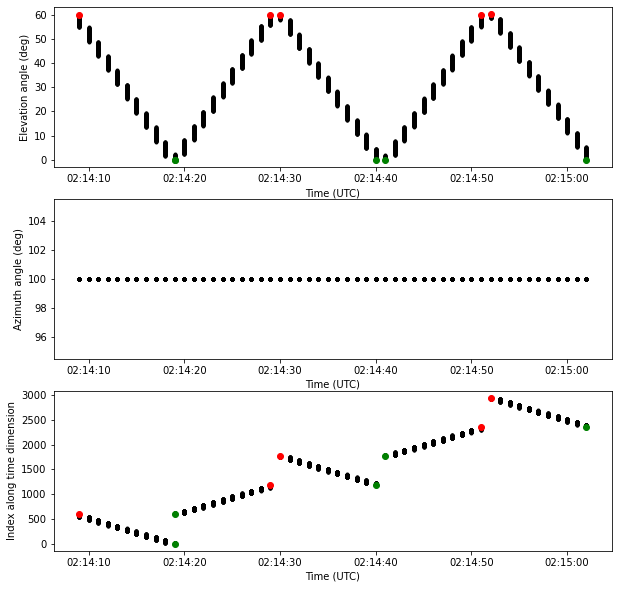

In [3]:
print(d.sweep_mode)
print(d.sweep_start_ray_index)
print(d.sweep_end_ray_index)

az = d.azimuth[:]
el = d.elevation[:]
t = d.time[:]
fig, axs = plt.subplots(3,1, squeeze=False, figsize=(10,10))

axs[0,0].plot(t,el, '.k')
axs[0,0].set_ylabel('Elevation angle (deg)')
axs[0,0].set_xlabel('Time (UTC)')
axs[1,0].plot(t,az, '.k')
axs[1,0].set_ylabel('Azimuth angle (deg)')
axs[1,0].set_xlabel('Time (UTC)')
axs[2,0].plot(t, np.arange(t.shape[0]), '.k')
axs[2,0].set_ylabel('Index along time dimension')
axs[2,0].set_xlabel('Time (UTC)')
for sw_start, sw_end in zip(d.sweep_start_ray_index, d.sweep_end_ray_index):
    axs[0,0].plot(t[sw_start], el[sw_start], marker='o', color='g')
    axs[0,0].plot(t[sw_end], el[sw_end], marker='o',color='r')
    axs[2,0].plot(t[sw_start], sw_start, marker='o', color='g')
    axs[2,0].plot(t[sw_end], sw_end, marker='o',color='r')

The green dots mark the start of a sweep according to `sweep_start_ray_index`, and red marks the end according to `sweep_end_ray_index`. We observe that:

0. the scans are in [RHI](http://ww2010.atmos.uiuc.edu/(Gh)/guides/rs/rad/basics/cnmod.rxml) mode, per the scan_mode variable.
1. the data have time precision of 1 s
2. the data are not stored in time order.
3. the data are stored in the file in order of increasing elevation angle, not increasing time.
4. azimuth angle is constant.

For the rest of this assignment, let's work with the second of the five scans, where time and elevation both increase with index along the time dimension. Reuse this variable instead of hard-coding a scan number in later code.

In [4]:
scan_idx = 1

**1.** Let's start by preparing the coordinates needed to plot a scan. Write a function that takes a radar dataset and scan index, and returns  D arrays of ranges, azimuths, and elevations that correspond to the edges of each radar sample (a.k.a., each gate). Your function should return three separate 2d variables, as you see in the sample function call below. I found it helpful to visualize how the coordinates were distributed in 2D a quick, unlableled plot of each coordinate: `plt.imshow(r)`.

In [5]:
#Define the start and the end of the scan index
idx_start = d.sweep_start_ray_index[scan_idx]
idx_end = d.sweep_end_ray_index[scan_idx]

#Create a definition that reads in the downloaded radar data and the scan index. Three arrays are created for the range, 
#azimuth, and elevation using the scan indexing
def coords(data, scan):  
    '''Reads in the radar data and the scan index and places them into an array
    Return:
    r_1d = array of the range
    az_1d = array of the azimuth
    el_1d = array of the elevation
    '''
    r_1d = np.array(data.range)
    az_1d = np.array(data.azimuth[idx_start.values:idx_end.values+1])
    el_1d = np.array(data.elevation[idx_start.values:idx_end.values+1])
    
    return r_1d, az_1d, el_1d

#Call the coords definition using dataset (d) and scan index (scan_idx)
r, az, el = coords(d, scan_idx)

#Create a definition that creates three 2-d arrays for the range, azimuth, and elevation
def coords_2d(r, az, el):
    '''Reads in the range, azimuth, and elevation 1-d arrays from the coords definition and creates
       a 2-d array using meshgrids
       
       Returns:
       r_2d = 2-d array of the range
       az_2d = 2-d array of the azimuth
       el_2d = 2-d array of the elevation
       
    '''
    r_2d, az_2d = np.meshgrid(r, az)
    r_2d, el_2d = np.meshgrid(r, el)
  
    return r_2d, az_2d, el_2d

#Call the coords_2d definition using the range, azimuth, and elevation 1-d arrays from the first definition to 
# create the three 2-d arrays
range_2d, azimuth_2d, elevation_2d = coords_2d(r, az, el)

<span class="ecb">Not calculating edges from centers -3. </span>

**2.** Make a 4-panel plot of reflectivity, velocity, spectrum width, and normalized coherent power. Use `coordinateSystems.RadarCoordinateSystem` to plot in altitude above vs. range along a tangent plane. The tangent plane should be centered at the location of radar.

Note that if you find that the coordinate transformations fail to preserve the shape of your input coordinate arrays, you can fix it with `X.shape = r.shape`, where `X` has been transformed from `r`.

In [6]:
#Import necessary modules
from metpy.plots import ctables
from coordinateSystems import TangentPlaneCartesianSystem
from coordinateSystems import RadarCoordinateSystem

#Assign specific colors bars to a variable to call later when plotting
NWSReflectivity = ctables.registry.get_colortable('NWSReflectivity')
NWSVelocity = ctables.registry.get_colortable('NWSVelocity')
NWSSpecWidth = ctables.registry.get_colortable('NWSSpectrumWidth')
NWSNorm = ctables.registry.get_colortable('Carbone42')

#Using the RadarCoordinateSystem definition from the coordinateSystems.py file, use the latitude, longitude, and altitude values
#from the radar dataset and then transform the 2-d arrays
radar = RadarCoordinateSystem(d.latitude, d.longitude, d.altitude)
X, Y, Z = radar.toECEF(range_2d, azimuth_2d, elevation_2d)

##Using the TangentPlaneCartesianSystem definition from the coordinateSystems.py file, use the latitude, longitude, and altitude values
#from the radar dataset and then transform the 2-d arrays
tan = TangentPlaneCartesianSystem(d.latitude, d.longitude, d.altitude)
X1, Y1, Z1 = tan.fromECEF(X, Y, Z)

#Redefine the sweep index 
idx_start_plot = d.sweep_start_ray_index[scan_idx]
idx_end_plot = d.sweep_end_ray_index[scan_idx]

#Create the arrays for reflectivity, velocity, spectrum width, and normalized coherent power
reflect = np.array(d.reflectivity[idx_start_plot.values:idx_end_plot.values+1])
velocity = np.array(d.velocity[idx_start_plot.values:idx_end_plot.values+1])
spec_wid = np.array(d.spectrum_width[idx_start_plot.values:idx_end_plot.values+1])
norm_co_power = np.array(d.normalized_coherent_power[idx_start_plot.values:idx_end_plot.values+1])

#Make sure that the shapes of the X1, Y1, Z1 match the range, azimuth, and elevation shapes
X1.shape = range_2d.shape
Y1.shape = azimuth_2d.shape
Z1.shape = elevation_2d.shape

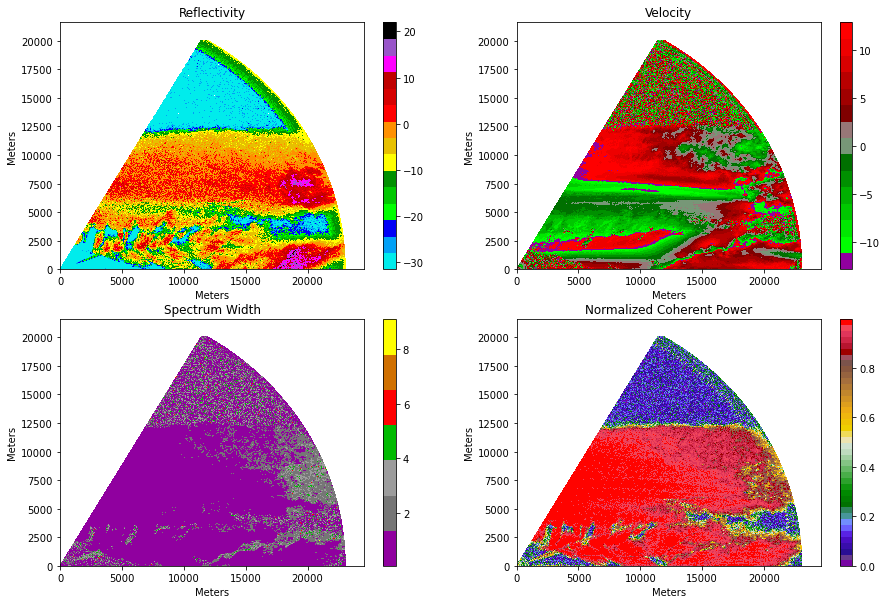

In [7]:
#Create a four panel plot that plots the reflectivity, velocity, spectrum width, and normalized coherent power
fig, axs = plt.subplots(2,2, squeeze=False, figsize=(15,10))

#Plotting the reflectivity
im1 = axs[0,0].pcolormesh(X1, Z1, reflect, cmap = NWSReflectivity)
axs[0,0].set_title('Reflectivity')
axs[0,0].set_xlabel('Meters')
axs[0,0].set_ylabel('Meters')
plt.colorbar(im1, ax=axs[0,0])
  
#Plotting the velocity 
im2 = axs[0,1].pcolormesh(X1, Z1, velocity, cmap = NWSVelocity)
axs[0,1].set_title('Velocity')
axs[0,1].set_xlabel('Meters')
axs[0,1].set_ylabel('Meters')
plt.colorbar(im2, ax=axs[0,1])

#Plotting the spectrum width
im3 = axs[1,0].pcolormesh(X1, Z1, spec_wid, cmap = NWSSpecWidth)
axs[1,0].set_title('Spectrum Width')
axs[1,0].set_xlabel('Meters')
axs[1,0].set_ylabel('Meters')
plt.colorbar(im3, ax=axs[1,0])  

#Plotting the normalized coherent power
im4 = axs[1,1].pcolormesh(X1, Z1, norm_co_power, cmap = NWSNorm)
axs[1,1].set_title('Normalized Coherent Power')
axs[1,1].set_xlabel('Meters')
axs[1,1].set_ylabel('Meters')
plt.colorbar(im4, ax=axs[1,1])

<span class="ecb">You plotted the x coordinate along the tangent plane instead of distance along the tangent plane from TPCS x and y -2. Axis labels are missing coordinate name. -1 </span>

**3.** Repeat the plot for question 2, but for an azimuthal equidistant map projection centered at the radar location.

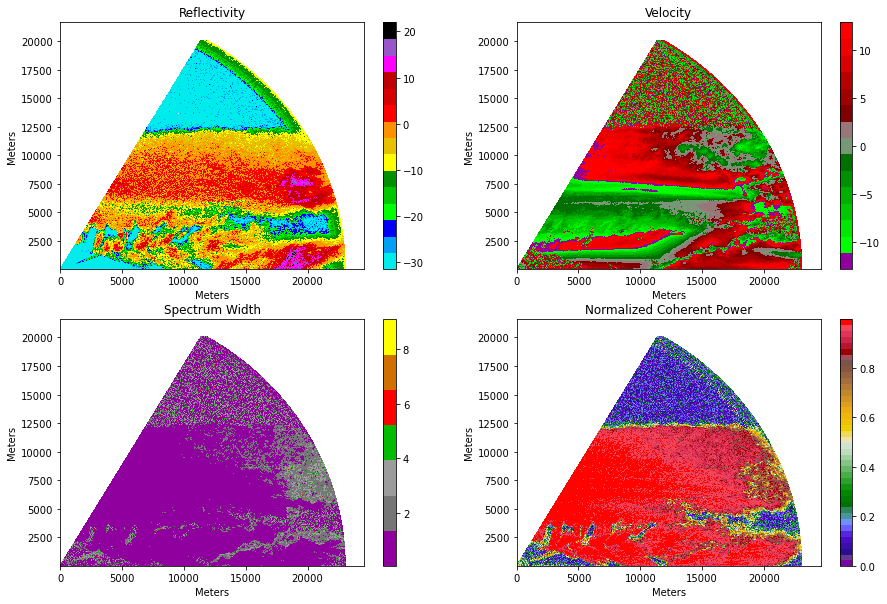

In [8]:
#Set the longitude and latitude values in the dataset to a variable
lon = d.longitude.values
lat = d.latitude.values

#Import MapProjection definition from the coordinateSystems.py file
from coordinateSystems import MapProjection


az_equi = MapProjection(projection = 'aeqd', lon_0 = lon, lat_0 = lat)
X_az, Y_az, Z_az = az_equi.fromECEF(X, Y, Z)

#Making sure that the X, Y, and Z shapes match the shapes from the 2-d range, azimuth, and elevation arrays
X_az.shape = range_2d.shape
Y_az.shape = azimuth_2d.shape
Z_az.shape = elevation_2d.shape

#Create a four panel plot of the new reflectivity, velocity, spectrum width, and normalized coherent power
fig, axs = plt.subplots(2,2, squeeze=False, figsize=(15,10))

#Plotting relfectivity
im1 = axs[0,0].pcolormesh(X_az, Z_az, reflect, cmap = NWSReflectivity)
axs[0,0].set_title('Reflectivity')
axs[0,0].set_xlabel('Meters')
axs[0,0].set_ylabel('Meters')
plt.colorbar(im1, ax=axs[0,0])
                   
#Plotting velocity
im2 = axs[0,1].pcolormesh(X_az, Z_az, velocity, cmap = NWSVelocity)
axs[0,1].set_title('Velocity')
axs[0,1].set_xlabel('Meters')
axs[0,1].set_ylabel('Meters')
plt.colorbar(im2, ax=axs[0,1])

#Plotting spectrum width
im3 = axs[1,0].pcolormesh(X_az, Z_az, spec_wid, cmap = NWSSpecWidth)
axs[1,0].set_title('Spectrum Width')
axs[1,0].set_xlabel('Meters')
axs[1,0].set_ylabel('Meters')
plt.colorbar(im3, ax=axs[1,0])  

#Plotting normalized coherent power
im4 = axs[1,1].pcolormesh(X_az, Z_az, norm_co_power, cmap = NWSNorm)
axs[1,1].set_title('Normalized Coherent Power')
axs[1,1].set_xlabel('Meters')
axs[1,1].set_ylabel('Meters')
plt.colorbar(im4, ax=axs[1,1])

<span class="ecb">You plotted the x coordinate of the projection instead of distance along the projection plane from x and y -2.</span>

To set the stage for the next two assignments, let's say we want to oversample the 15 m range gates to a 5 m carteisian grid in the domain 9.0…9.5 km range and 2.9…3.4 km altitude. Once again, we will use the distance above and the range along the tangent plane.

**4.** Create 2D arrays giving the corresponding center locations for each desired analysis location. Start with 1D grid box edges spanning the range above.

In [9]:
#Code from homework 1 to transform from edges to centers
def edges_to_centers_1d(x):
    #take the absolute value of the center pointsa and then take the average 
    dx = np.absolute(x[1] - x[0])/2
    #make an array of the latitude and longitude values using the minimum and maximum value
    return np.arange(np.min(x) + dx, np.max(x) - dx + dx/2, 2*dx)

#Define the new range and altitude values 
new_r = np.arange(9000, 9505, 5)
new_alt = np.arange(2900, 3405, 5)


edge_to_center_r = edges_to_centers_1d(new_r)
edge_to_center_alt = edges_to_centers_1d(new_alt)

#Create the 2-d array
r_center_2d, alt_center_2d = np.meshgrid(edge_to_center_r, edge_to_center_alt)

# print(r_center_2d)
# print(alt_center_2d)

**5.** For the next question, we will interpolate in three ways:
- nearest neighbor
- linear
- the traditional meteorological "Barnes" analysis (which is really a Gaussian blur fliter). 

To do so, we will use MetPy's built-in interpolators. It wraps SciPy's built-in nearest and linear interpolation methods, and adds Barnes, natural neighbor, and other interpolators. 

You will probably need to install metpy with `conda install -c conda-forge metpy`.

Once you have installed MetPy, use its `interpolate_to_points` function. Note that it takes three arguments, and those arguments require that you use `np.vstack` to rearrange the locations and data into the correct shape.

So that the Barnes analysis doesn't take forever, you will want to subset the data to only those locations that overlap with the analysis grid.

In [10]:
#Import necessary modules
from metpy.interpolate import interpolate_to_points
#interpolate_to_points?

#Nearest Neighbor Interpolation Method
#Complete a vstack of the X and Z variable calculated in question 3
stack_data = np.column_stack((np.concatenate(X_az), np.concatenate(Z_az)))
vstack_data = np.vstack((X_az, Z_az))
transpose = np.transpose(vstack_data)

#Using the interpolate_to_points, we will interpolate the new stacked data, the reflectivity, and the range and altitude from part 4
#The method being used is the nearest neighbor method
reflect_nearest = interpolate_to_points(stack_data, np.concatenate(reflect),(r_center_2d, alt_center_2d), interp_type ='nearest')
velocity_nearest = interpolate_to_points(stack_data, np.concatenate(velocity),(r_center_2d, alt_center_2d), interp_type ='nearest')
spec_nearest = interpolate_to_points(stack_data, np.concatenate(spec_wid),(r_center_2d, alt_center_2d), interp_type ='nearest')
norm_nearest = interpolate_to_points(stack_data, np.concatenate(norm_co_power),(r_center_2d, alt_center_2d), interp_type ='nearest')

In [11]:
#Linear Interpolation Method

#Using the interpolate_to_points, we will interpolate the new stacked data, the reflectivity, and the range and altitude from part 4
# The method being used is linear interpolation 
reflect_linear = interpolate_to_points(stack_data, np.concatenate(reflect),(r_center_2d, alt_center_2d), interp_type ='linear')
velocity_linear = interpolate_to_points(stack_data, np.concatenate(velocity),(r_center_2d, alt_center_2d), interp_type ='linear')
spec_linear = interpolate_to_points(stack_data, np.concatenate(spec_wid),(r_center_2d, alt_center_2d), interp_type ='linear')
norm_linear = interpolate_to_points(stack_data, np.concatenate(norm_co_power),(r_center_2d, alt_center_2d), interp_type ='linear')

In [12]:
#Barnes Interpolation Method

#Flatten the X and Z from the AEQD
barnes_x = X_az.flatten()
barnes_z = Z_az.flatten()

#Define the bounds that we will be looking at
range_barnes = np.logical_and(barnes_x>9000, barnes_x<9505)
elevation_barnes = np.logical_and(barnes_z>2900, barnes_z<3405)

#Subset the data so that it runs faster
subset = np.logical_and(range_barnes, elevation_barnes)
subset.shape = range_2d.shape

X_subset = X_az[subset]
Z_subset = Z_az[subset]

reflect_subset = reflect[subset]
velocity_subset = velocity[subset]
spec_subset = spec_wid[subset]
norm_subset = norm_co_power[subset]

#Define our new points using the subset X and Z
points = np.column_stack((X_subset, Z_subset))

#Using the interpolate_to_points, we will interpolate the new stacked data, the reflectivity, and the range and altitude from part 4
# The method being used is barnes interpolation 
reflect_barnes = interpolate_to_points(points, (reflect_subset), np.column_stack((np.concatenate(r_center_2d), np.concatenate(alt_center_2d))), interp_type ='barnes')
velocity_barnes = interpolate_to_points(points, (velocity_subset), np.column_stack((np.concatenate(r_center_2d), np.concatenate(alt_center_2d))), interp_type ='barnes')
spec_barnes = interpolate_to_points(points, (spec_subset), np.column_stack((np.concatenate(r_center_2d), np.concatenate(alt_center_2d))), interp_type ='barnes') 
norm_barnes = interpolate_to_points(points, (norm_subset), np.column_stack((np.concatenate(r_center_2d), np.concatenate(alt_center_2d))), interp_type ='barnes')

#Reshape
reflect_barnes.shape = reflect_linear.shape
velocity_barnes.shape = velocity_linear.shape
spec_barnes.shape = spec_linear.shape
norm_barnes.shape = norm_linear.shape

**6.** Make a plot of the original data and the three interpolation methods. Compared to the original data, what do the three interpolation methods do to the data? Think about what you would regard as desirable properties of an analysis.

Text(0, 0.5, 'Meters')

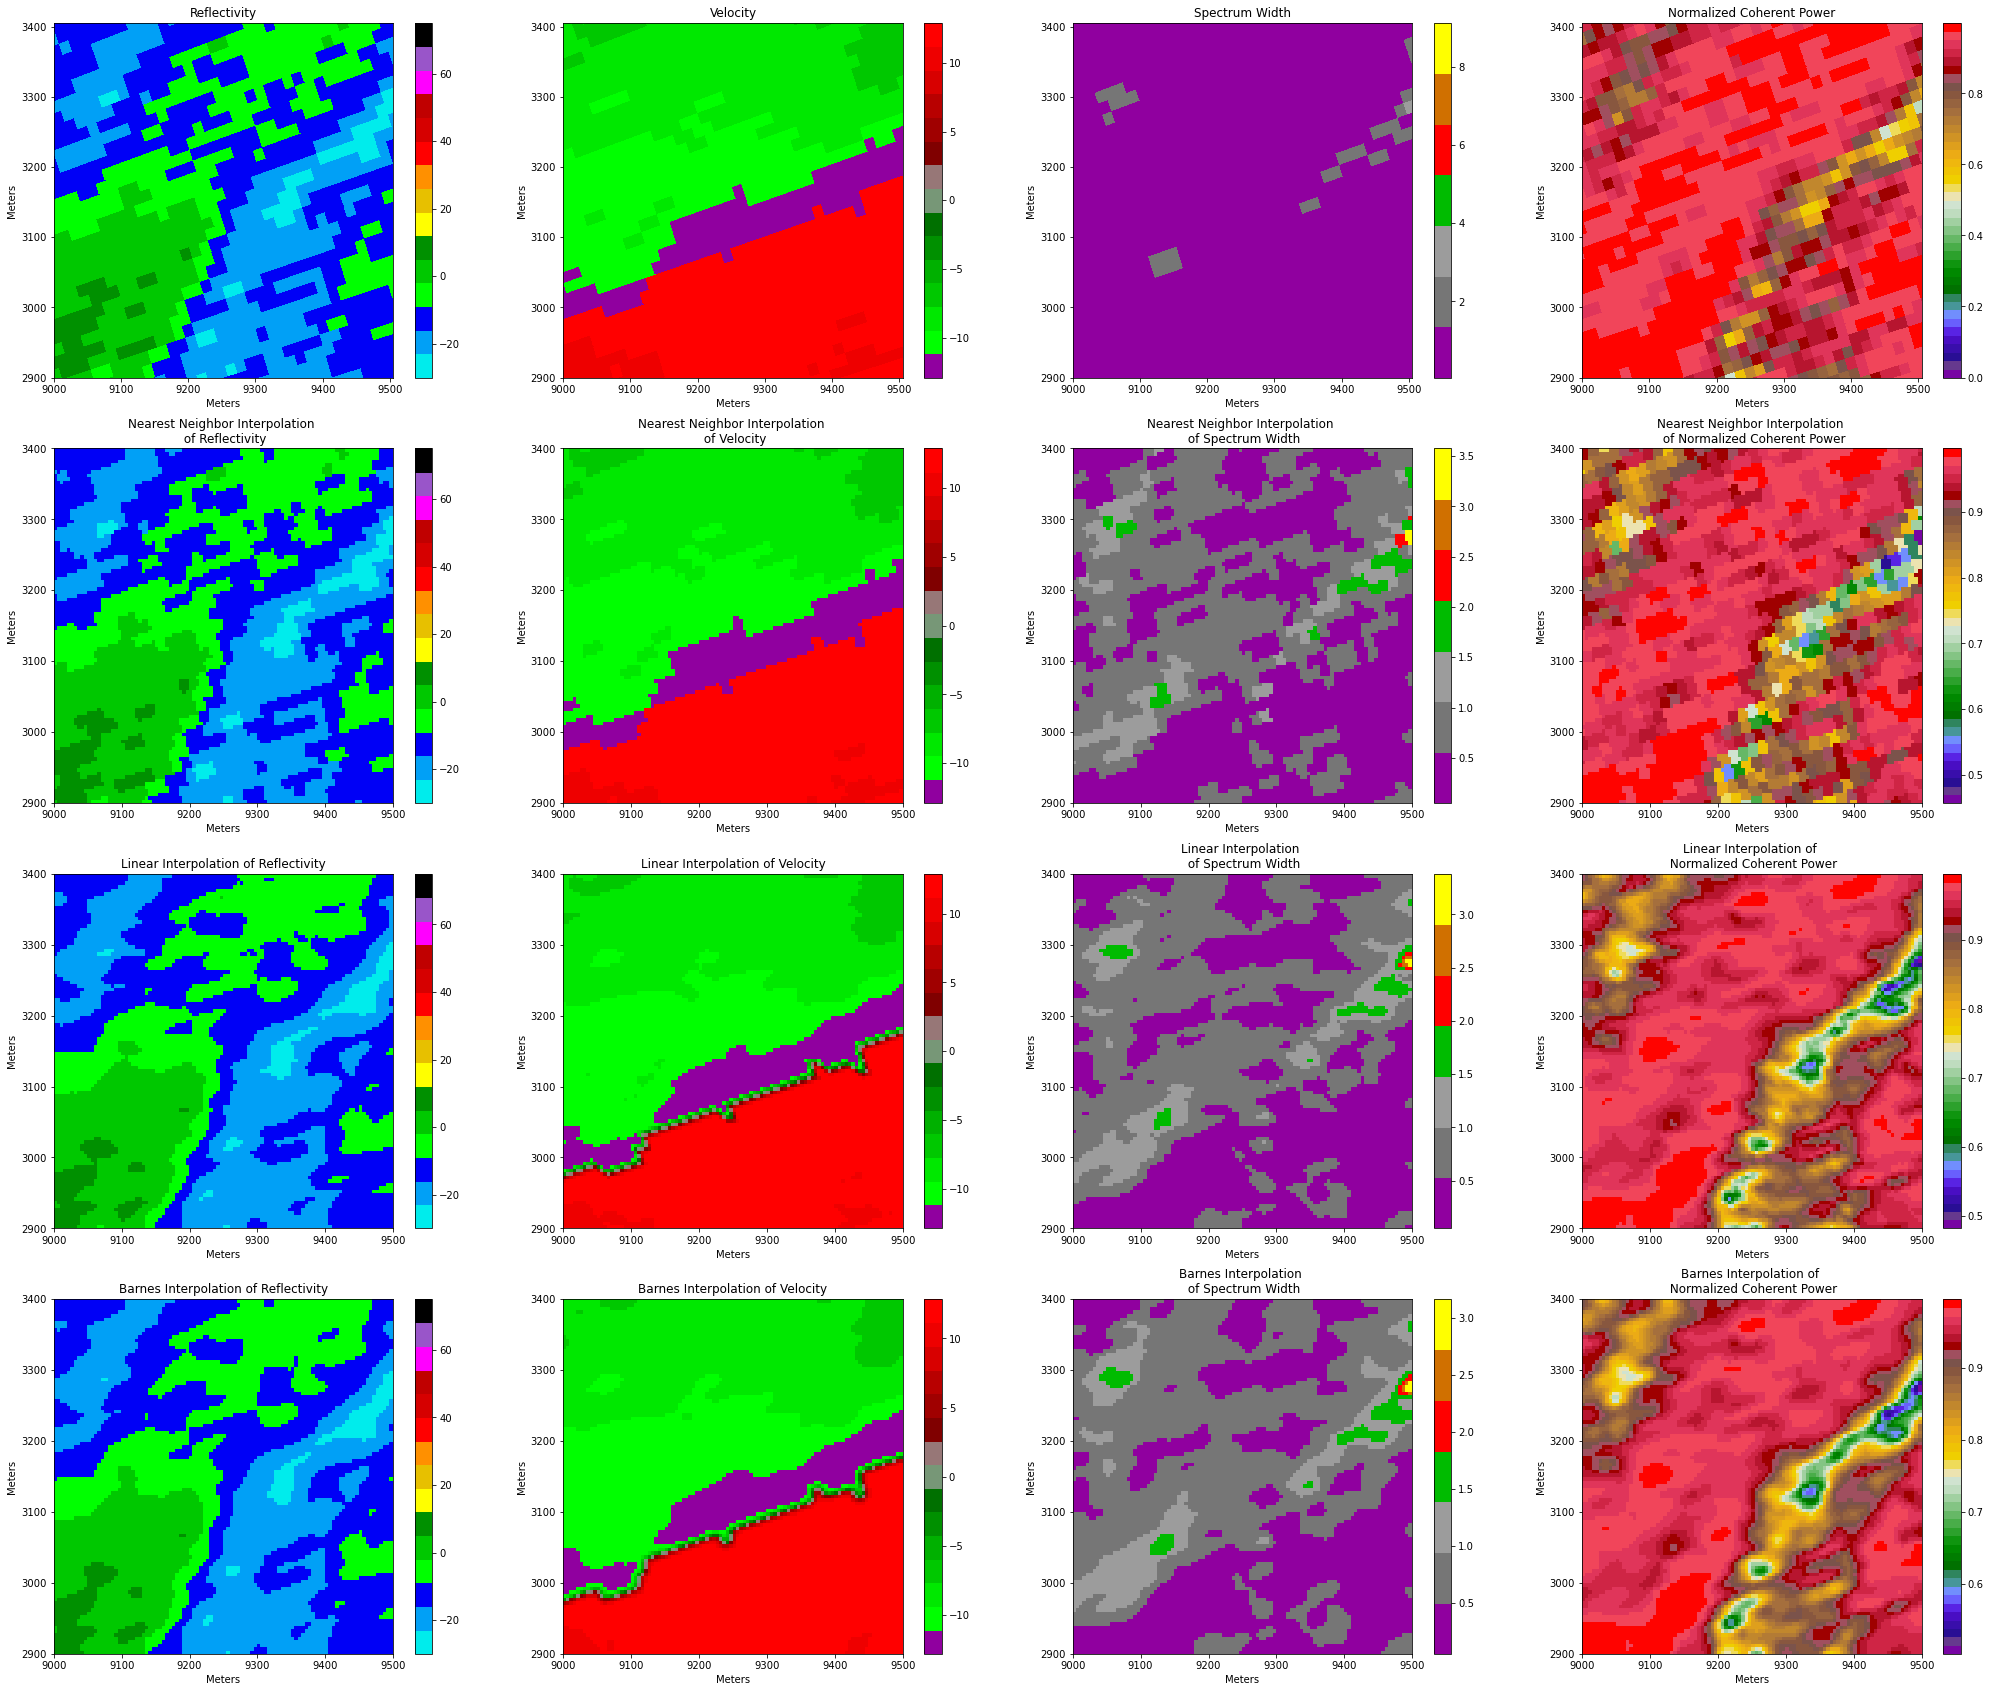

In [14]:
#Import Normalize from matplotlib in order to change the range of the reflectivity from -30 to 75 (which is a normal reflectivity
# range)
from matplotlib.colors import Normalize
fig, axs = plt.subplots(4,4, squeeze=False, figsize=(35,30))

#Original Data: Reflectivity
im1 = axs[0,0].pcolormesh(X_az, Z_az, reflect, cmap = NWSReflectivity, norm = Normalize(-30,75))
axs[0,0].set_title('Reflectivity')
axs[0,0].set_xlim(9000, 9505)
axs[0,0].set_ylim(2900, 3405)
axs[0,0].set_xlabel('Meters')
axs[0,0].set_ylabel('Meters')
plt.colorbar(im1, ax=axs[0,0])
   
#Original Data: Velocity 
im2 = axs[0,1].pcolormesh(X_az, Z_az, velocity, cmap = NWSVelocity)
axs[0,1].set_title('Velocity')
plt.colorbar(im2, ax=axs[0,1])
axs[0,1].set_xlim(9000, 9505)
axs[0,1].set_ylim(2900, 3405)
axs[0,1].set_xlabel('Meters')
axs[0,1].set_ylabel('Meters')

#Original Data: Spectrum Width
im3 = axs[0,2].pcolormesh(X_az, Z_az, spec_wid, cmap = NWSSpecWidth)
axs[0,2].set_title('Spectrum Width')
plt.colorbar(im3, ax=axs[0,2]) 
axs[0,2].set_xlim(9000, 9505)
axs[0,2].set_ylim(2900, 3405)
axs[0,2].set_xlabel('Meters')
axs[0,2].set_ylabel('Meters')

#Original Data: Normal Coherent Power
im4 = axs[0,3].pcolormesh(X_az, Z_az, norm_co_power, cmap = NWSNorm)
axs[0,3].set_title('Normalized Coherent Power')
plt.colorbar(im4, ax=axs[0,3])
axs[0,3].set_xlim(9000, 9505)
axs[0,3].set_ylim(2900, 3405)
axs[0,3].set_xlabel('Meters')
axs[0,3].set_ylabel('Meters')

#Plots for nearest neighbor: Reflectivity
im1 = axs[1,0].pcolormesh(new_r, new_alt, reflect_nearest, cmap = NWSReflectivity, norm = Normalize(-30,75))
axs[1,0].set_title('Nearest Neighbor Interpolation \n of Reflectivity')
plt.colorbar(im1, ax=axs[1,0])
axs[1,0].set_xlabel('Meters')
axs[1,0].set_ylabel('Meters')
     
#Plots for nearest neighbor: Velocity
im2 = axs[1,1].pcolormesh(new_r, new_alt, velocity_nearest, cmap = NWSVelocity)
axs[1,1].set_title('Nearest Neighbor Interpolation \n of Velocity')
plt.colorbar(im2, ax=axs[1,1])
axs[1,1].set_xlabel('Meters')
axs[1,1].set_ylabel('Meters')

#Plots for nearest neighbor: Spectrum Width
im3 = axs[1,2].pcolormesh(new_r, new_alt, spec_nearest, cmap = NWSSpecWidth)
axs[1,2].set_title('Nearest Neighbor Interpolation \n of Spectrum Width')
plt.colorbar(im3, ax=axs[1,2])
axs[1,2].set_xlabel('Meters')
axs[1,2].set_ylabel('Meters')

#Plots for nearest neighbor: Normal Coherent Power
im4 = axs[1,3].pcolormesh(new_r, new_alt, norm_nearest, cmap = NWSNorm)
axs[1,3].set_title('Nearest Neighbor Interpolation \n of Normalized Coherent Power')
plt.colorbar(im4, ax=axs[1,3])
axs[1,3].set_xlabel('Meters')
axs[1,3].set_ylabel('Meters')

#Plots for linear: Reflectivity
im1 = axs[2,0].pcolormesh(new_r, new_alt, reflect_linear, cmap = NWSReflectivity, norm = Normalize(-30,75))
axs[2,0].set_title('Linear Interpolation of Reflectivity')
plt.colorbar(im1, ax=axs[2,0])
axs[2,0].set_xlabel('Meters')
axs[2,0].set_ylabel('Meters')
                   
#Plots for linear: Velocity
im2 = axs[2,1].pcolormesh(new_r, new_alt, velocity_linear, cmap = NWSVelocity)
axs[2,1].set_title('Linear Interpolation of Velocity')
plt.colorbar(im2, ax=axs[2,1])
axs[2,1].set_xlabel('Meters')
axs[2,1].set_ylabel('Meters')

#Plots for linear: Spectrum Width
im3 = axs[2,2].pcolormesh(new_r, new_alt, spec_linear, cmap = NWSSpecWidth)
axs[2,2].set_title('Linear Interpolation \n of Spectrum Width')
plt.colorbar(im3, ax=axs[2,2])  
axs[2,2].set_xlabel('Meters')
axs[2,2].set_ylabel('Meters')

#Plots for linear: Normalized Coherent Power
im4 = axs[2,3].pcolormesh(new_r, new_alt, norm_linear, cmap = NWSNorm)
axs[2,3].set_title('Linear Interpolation of \n Normalized Coherent Power')
plt.colorbar(im4, ax=axs[2,3])
axs[2,3].set_xlabel('Meters')
axs[2,3].set_ylabel('Meters')

#Plots for Barnes: Reflectivity
im1 = axs[3,0].pcolormesh(new_r, new_alt, reflect_barnes, cmap = NWSReflectivity, norm = Normalize(-30,75))
axs[3,0].set_title('Barnes Interpolation of Reflectivity')
plt.colorbar(im1, ax=axs[3,0])
axs[3,0].set_xlabel('Meters')
axs[3,0].set_ylabel('Meters')

#Plots for Barnes: Velocity
im2 = axs[3,1].pcolormesh(new_r, new_alt, velocity_barnes, cmap = NWSVelocity)
axs[3,1].set_title('Barnes Interpolation of Velocity')
plt.colorbar(im2, ax=axs[3,1])
axs[3,1].set_xlabel('Meters')
axs[3,1].set_ylabel('Meters')

#Plots for Barnes: Spectrum Width
im3 = axs[3,2].pcolormesh(new_r, new_alt, spec_barnes, cmap = NWSSpecWidth)
axs[3,2].set_title('Barnes Interpolation \n of Spectrum Width')
plt.colorbar(im3, ax=axs[3,2])  
axs[3,2].set_xlabel('Meters')
axs[3,2].set_ylabel('Meters')

#Plots for Barnes: Normalized Coherent Power
im4 = axs[3,3].pcolormesh(new_r, new_alt, norm_barnes, cmap = NWSNorm)
axs[3,3].set_title('Barnes Interpolation of \n Normalized Coherent Power')
plt.colorbar(im4, ax=axs[3,3])
axs[3,3].set_xlabel('Meters')
axs[3,3].set_ylabel('Meters')

**Answer for 6:**

For all of the plots, we can see that the original plots are very pixelated. For each of the interpolation methods, they become less and less pixelated. The lines for the barnes interpolation method are the smoothest out of all of the methods. The intensities are generally the same for all of the plots except for the spectrum width and normal coherent power. The intricacies of the spectrum width pop out the most with the nearest neighbor, linear, and barnes. In general, you want your contours to be smoother and all of the intricacies to stand out. 